# Introduction

This kernel provides a very first step data exploration of the data with R.

The aim of this problem is to predict the price of items on online markets, given the item names, descriptions as well as other features. This is a mix of traditional machine learning problem and NLP problem.

I will be very appreciative if you find this kernel useful and give me an upvote. I will keep updating this kernel and please comment if you have any advice. 

# Loading Packages and Files

In [1]:
library(data.table) # Loading data
library(ggplot2) # Data visualization
library(treemapify) # Treemap visualization
library(gridExtra) # Create multiplot
library(dplyr) # data manipulation
library(tidyr) # data manipulation
library(tibble) # data wrangling
library(stringr) # String processing
library(repr)
library(stringi) # String processing


Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
train = fread('../input/train.tsv', sep='\t')
test = fread('../input/test.tsv', sep='\t')

Read 1482535 rows and 8 (of 8) columns from 0.315 GB file in 00:00:13
Read 693359 rows and 7 (of 7) columns from 0.144 GB file in 00:00:07


# Overview

The training data has 1482535 observations with 7 features. The test data has 693359 rows that we need to predict. According to the competition description, the public leaderboard will be evaluated by  ALL of the test data we have at the first stage.

The evaluation metrics is RMSLE, which gives more penalty on under-estimating prices rather than over-estimating. Due to the nature of RMSLE we take log of the price in our analysis.

In [3]:
head(train, 3)

train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,,10,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & Parts,Razer,52,0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10,1,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!"


In [4]:
summary(train)

    train_id           name           item_condition_id category_name     
 Min.   :      0   Length:1482535     Min.   :1.000     Length:1482535    
 1st Qu.: 370634   Class :character   1st Qu.:1.000     Class :character  
 Median : 741267   Mode  :character   Median :2.000     Mode  :character  
 Mean   : 741267                      Mean   :1.907                       
 3rd Qu.:1111900                      3rd Qu.:3.000                       
 Max.   :1482534                      Max.   :5.000                       
  brand_name            price            shipping      item_description  
 Length:1482535     Min.   :   0.00   Min.   :0.0000   Length:1482535    
 Class :character   1st Qu.:  10.00   1st Qu.:0.0000   Class :character  
 Mode  :character   Median :  17.00   Median :0.0000   Mode  :character  
                    Mean   :  26.74   Mean   :0.4473                     
                    3rd Qu.:  29.00   3rd Qu.:1.0000                     
                    Max.   :200

In [5]:
summary(test)

    test_id           name           item_condition_id category_name     
 Min.   :     0   Length:693359      Min.   :1.000     Length:693359     
 1st Qu.:173340   Class :character   1st Qu.:1.000     Class :character  
 Median :346679   Mode  :character   Median :2.000     Mode  :character  
 Mean   :346679                      Mean   :1.906                       
 3rd Qu.:520018                      3rd Qu.:3.000                       
 Max.   :693358                      Max.   :5.000                       
  brand_name           shipping      item_description  
 Length:693359      Min.   :0.0000   Length:693359     
 Class :character   1st Qu.:0.0000   Class :character  
 Mode  :character   Median :0.0000   Mode  :character  
                    Mean   :0.4477                     
                    3rd Qu.:1.0000                     
                    Max.   :1.0000                     

We can have a a rough look at the features (test data summary is hidden for simplicity)
1. **train_id / test_id**: A unique key for each item.
2. **name**: The item's name as a string.
3. **item_condition_id**: A factor with 5 levels. As the plot below shows, the mean prices for different conditions are really close and it's hard to guess which whether higher / lower condition id is better so far.
4. **category_name**: The category of the item.
5. **brand_name**: The brand name of the item. Nearly half of the items do not have a brand.
6. **shipping**: A binary indicator of the shipping information. (1 if shipping fee is paid by seller and 0 by buyer)
7. **item_description**: A long string containing the raw text of the item description. ~5% of the items do not have a description.

# Feature Visualizations

## Prices and Indicators

As the figures below show, the distribution of log price is more normally-distributed than the orginal scale of price.

In [6]:
train = train %>% mutate(log_price = log(price+1)) # take log of the price
train = train %>% mutate(item_condition_id = factor(item_condition_id))
train = train %>% mutate(shipping = factor(shipping))

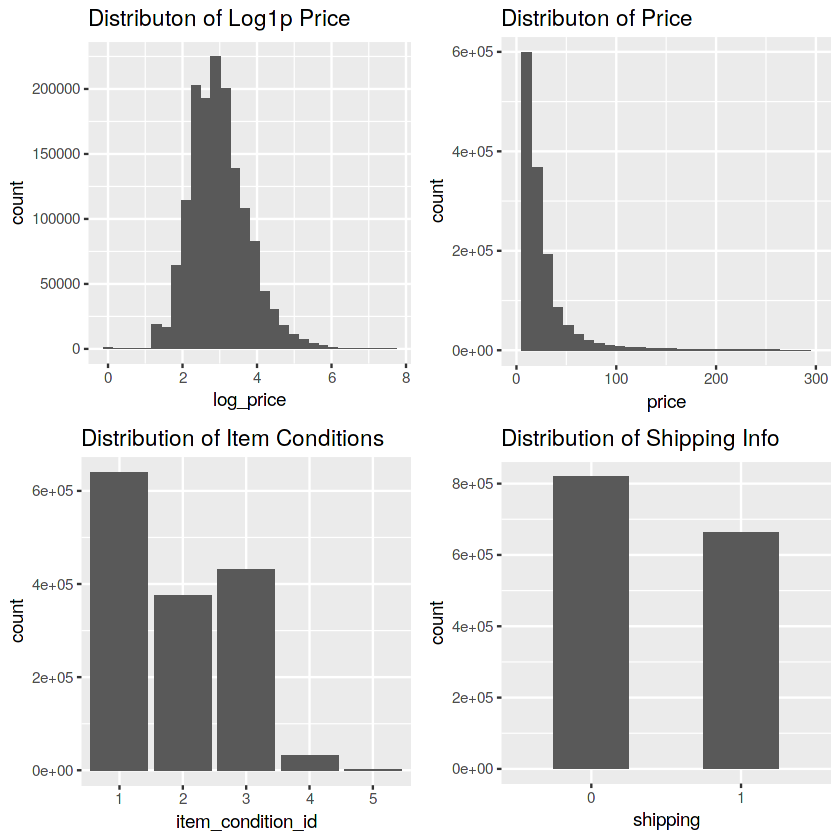

In [7]:
options(repr.plot.width=7, repr.plot.height=7)

p1 = train %>% ggplot(aes(x=log_price)) +
geom_histogram(bins=30) +
ggtitle('Distributon of Log1p Price')

p2 = train %>% ggplot(aes(x=price)) +
geom_histogram(bins=30) +
xlim(0,300) +
ggtitle('Distributon of Price')

p3 = train %>% ggplot(aes(x=item_condition_id)) +
geom_bar() +
ggtitle('Distribution of Item Conditions') +
theme(legend.position="none")

p4 = train %>% ggplot(aes(x=shipping)) +
geom_bar(width=0.5) +
ggtitle('Distribution of Shipping Info') +
theme(legend.position="none")

suppressWarnings(grid.arrange(p1, p2, p3, p4, ncol=2))

## Categories and Brands

We notice that the category_name is actually encoded as three or four hierarchical levels splitted by /. (Thanks to [Abhinav Reddy Kaitha](https://www.kaggle.com/abhinavkaitha) there are some items with four levels instead of three)

We can split the category names and store them into 4 columns. The major category (1st category) only has 11 levels and we can make distinguishable visualizations on them. From the 2nd level on the # of levels are too many to visualize.

Most items only have three levels of categories. But the 4th level exists with 8 unique sub-categories and 4389 items. For modeling perspective it may be fine to combine it with 3rd levels but for analysis purpose I extract and keep the 4th level here.

In [8]:
train = data.frame(train, str_split_fixed(train$category_name, '/', 4)) %>%
mutate(cat1=X1, cat2=X2, cat3=X3, cat4=X4) %>% select(-X1, -X2, -X3, -X4)

train %>% summarise(Num_Cat1 = length(unique(cat1)), Num_Cat2 = length(unique(cat2)),
Num_Cat3 = length(unique(cat3)), Num_Cat4 = length(unique(cat4)))

Num_Cat1,Num_Cat2,Num_Cat3,Num_Cat4
11,114,871,8


In [9]:
train %>% filter(cat4 != '') %>% nrow

[1] 4389

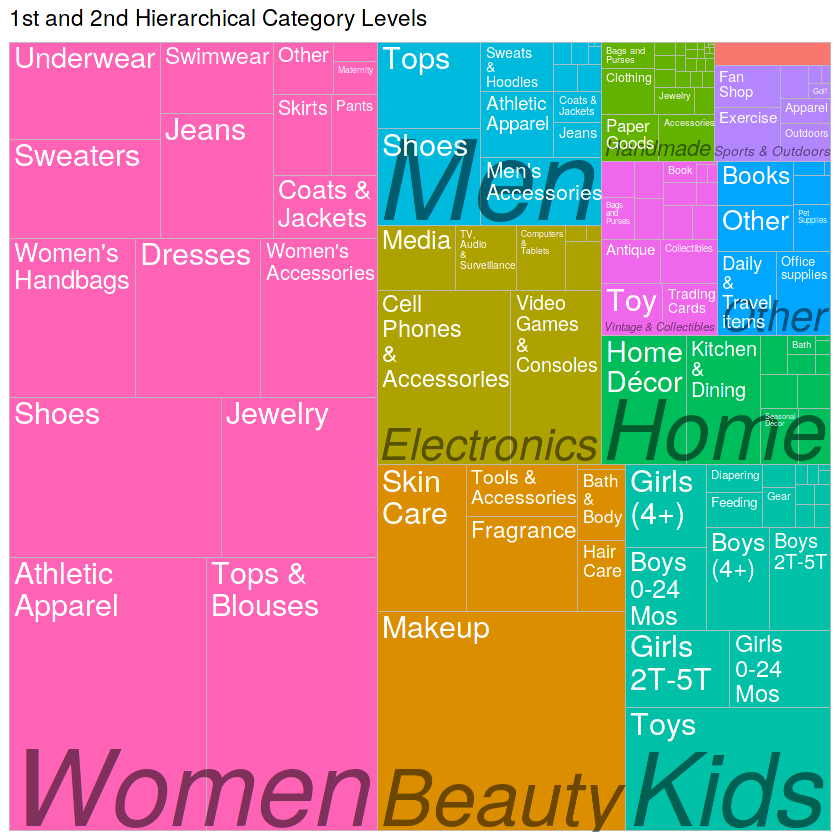

In [10]:
options(repr.plot.width=7, repr.plot.height=7)

train %>%
group_by(cat1, cat2) %>%
count() %>%
ungroup() %>%
ggplot(aes(area=n, fill=cat1, label=cat2, subgroup=cat1)) +
geom_treemap() +
geom_treemap_subgroup_text(grow = T, alpha = 0.5, colour =
                           "black", fontface = "italic", min.size = 0) +
geom_treemap_text(colour = "white", place = "topleft", reflow = T) +
theme(legend.position = "null") +
ggtitle("1st and 2nd Hierarchical Category Levels")

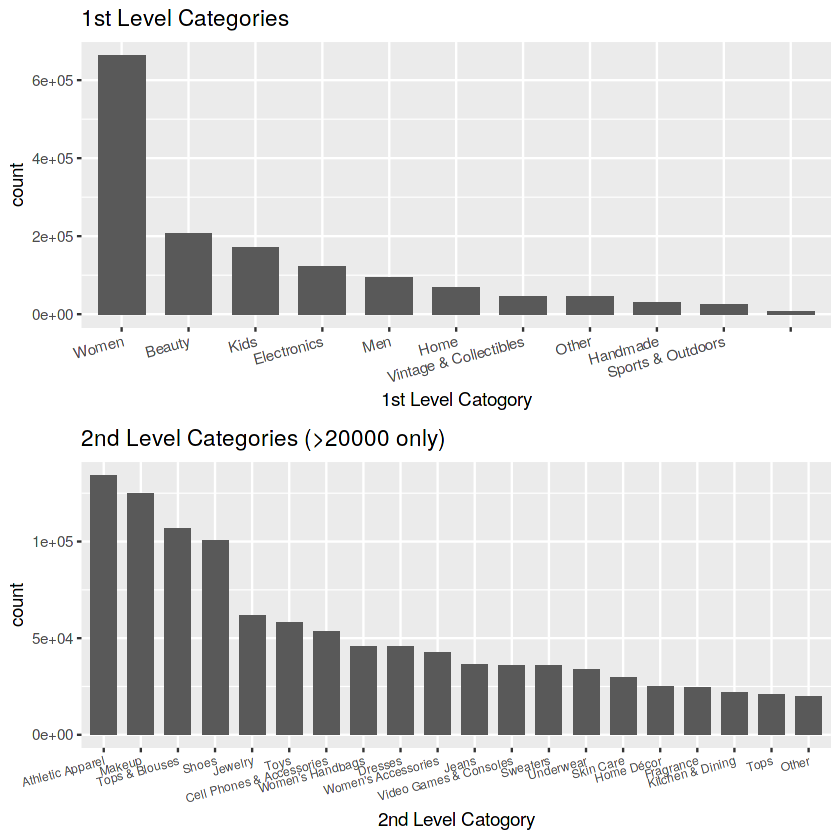

In [11]:
options(repr.plot.width=7, repr.plot.height=7)

p1 = train %>% count(cat1) %>% 
ggplot(aes(x=reorder(cat1, -n), y=n)) +
geom_bar(stat='identity', width=0.7) +
ggtitle('1st Level Categories') +
xlab('1st Level Catogory') +
ylab('count') +
theme(axis.text.x=element_text(angle=15, hjust=1))

p2 = train %>% count(cat2) %>% 
filter(n>20000) %>% 
ggplot(aes(x=reorder(cat2,-n), y=n)) +
geom_bar(stat='identity', width=0.7) +
ggtitle('2nd Level Categories (>20000 only)') +
xlab('2nd Level Catogory') +
ylab('count') +
theme(axis.text.x=element_text(angle=15, hjust=1, size=7))

grid.arrange(p1, p2, ncol=1)

For visualizing I only subset the 2nd categories with 20000+ items.

It appears that the major 1st level category in this online shopping market is Women. So let's take a step into it and look at the 2nd category under women. It appears most items are clothings and accessories.

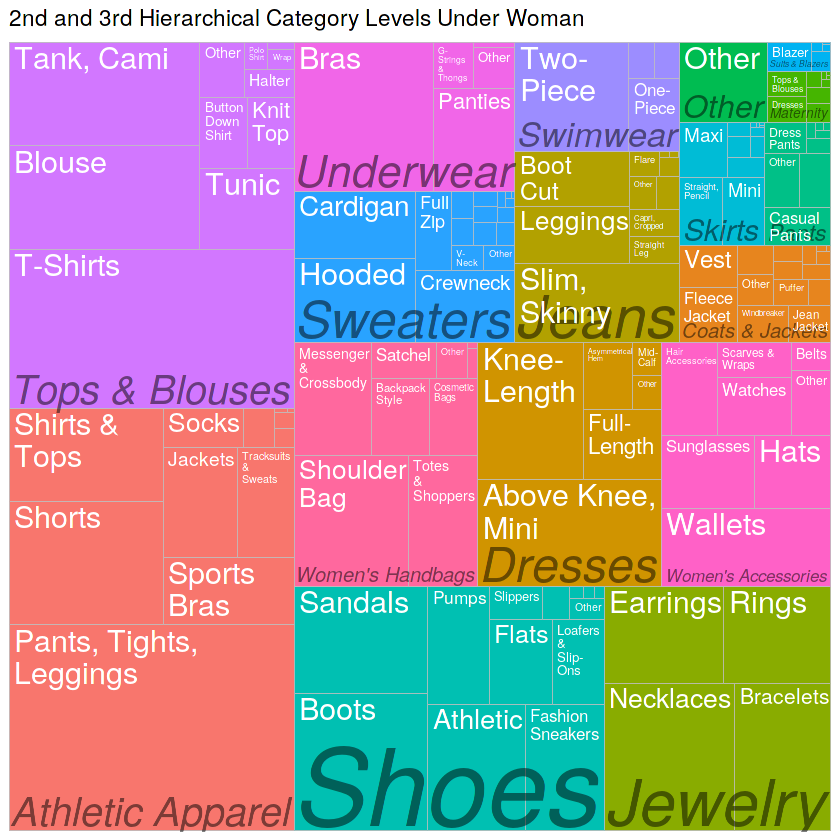

In [12]:
options(repr.plot.width=7, repr.plot.height=7)

train %>% filter(cat1=='Women') %>% 
group_by(cat2, cat3) %>%
count() %>%
ungroup() %>%
ggplot(aes(area=n, fill=cat2, label=cat3, subgroup=cat2)) +
geom_treemap() +
geom_treemap_subgroup_text(grow = T, alpha = 0.5, colour =
                           "black", fontface = "italic", min.size = 0) +
geom_treemap_text(colour = "white", place = "topleft", reflow = T) +
theme(legend.position = "null") +
ggtitle("2nd and 3rd Hierarchical Category Levels Under Woman")

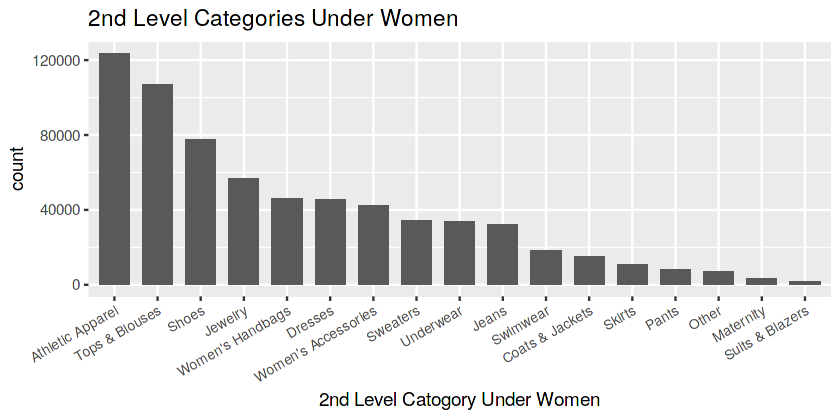

In [13]:
options(repr.plot.width=7, repr.plot.height=3.5)

train %>% filter(cat1=='Women') %>%
count(cat2) %>% 
ggplot(aes(x=reorder(cat2, -n), y=n)) +
geom_bar(stat='identity', width=0.7) +
ggtitle('2nd Level Categories Under Women') +
xlab('2nd Level Catogory Under Women') +
ylab('count') +
theme(axis.text.x=element_text(angle=30, hjust=1, size=8))

Nearly half of the items don't have brands. The proportions of items that have brands vary in different categories. For example, Nearly all handmade items don't have brand names, of course.

For brands, they are not in a hierarchical order and there are too many to be fitted in one graph. So I plotted the count of top 10 most frequent brands for a rough look. Each brand contains items from 1 or more major categories. Not surprisingly, the top brands are dominated by women items except Apple and Nintendo.

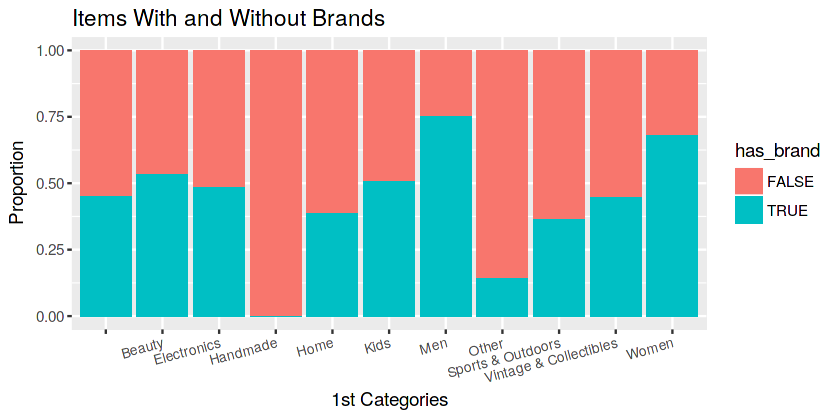

In [14]:
options(repr.plot.width=7, repr.plot.height=3.5)

train = train %>% mutate(has_brand=(brand_name!=''))
train %>%
ggplot(aes(x=cat1, fill=has_brand)) +
geom_bar(position='fill') +
theme(axis.text.x=element_text(angle=15, hjust=1, size=8)) +
xlab('1st Categories') +
ylab('Proportion') +
ggtitle('Items With and Without Brands')

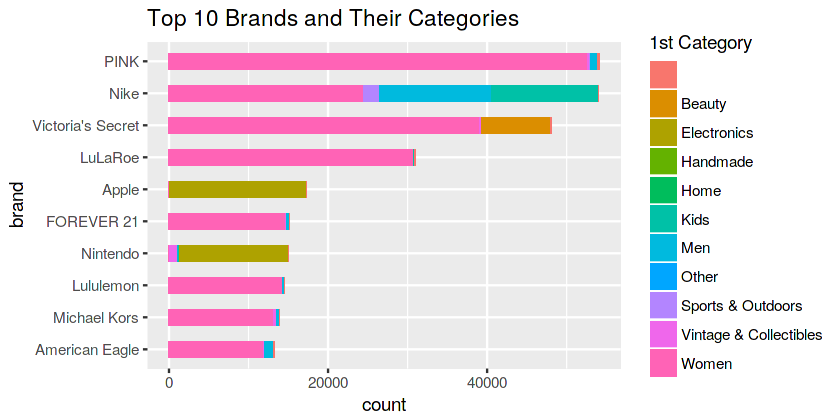

In [15]:
options(repr.plot.width=7, repr.plot.height=3.5)

top10 = train %>% filter(brand_name!='') %>% 
count(brand_name) %>%
arrange(desc(n)) %>%
head(10)

train %>% filter(brand_name %in% top10$brand_name) %>%
ggplot(aes(x=factor(brand_name, levels=rev(top10$brand_name)), fill=cat1)) +
geom_bar(width=0.5) +
coord_flip() +
xlab('brand') +
labs(fill='1st Category') +
ggtitle('Top 10 Brands and Their Categories')

## Item Descriptions

For the item description, I extract two most simple features of the text: the length of the text and the number of words of the text. It shows that both of them have a exponential distribution with a long tail.

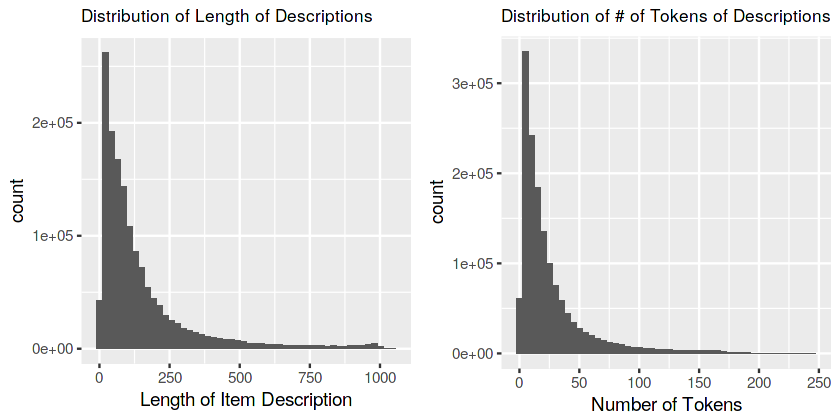

In [16]:
options(repr.plot.width=7, repr.plot.height=3.5)

p1 = train %>% mutate(len_of_des = str_length(item_description)) %>%
ggplot(aes(x=len_of_des)) +
geom_histogram(bins=50) +
ggtitle('Distribution of Length of Descriptions') +
xlab('Length of Item Description') +
theme(plot.title = element_text(size=10))

p2 = train %>% mutate(num_token_des = str_count(item_description, '\\S+')) %>% 
ggplot(aes(x=num_token_des)) +
geom_histogram(bins=50) +
ggtitle('Distribution of # of Tokens of Descriptions') +
xlab('Number of Tokens') +
theme(plot.title = element_text(size=10))

grid.arrange(p1, p2, ncol=2)

## Names

Name is a very important feature —— it directly tell us what the items are. But it's hard to be categorized or one-hot encoded because there are 1225273 uniqle names for all the items. We should find some ways to extract the information from the item name.

In [17]:
length(unique(train$name))

[1] 1225273

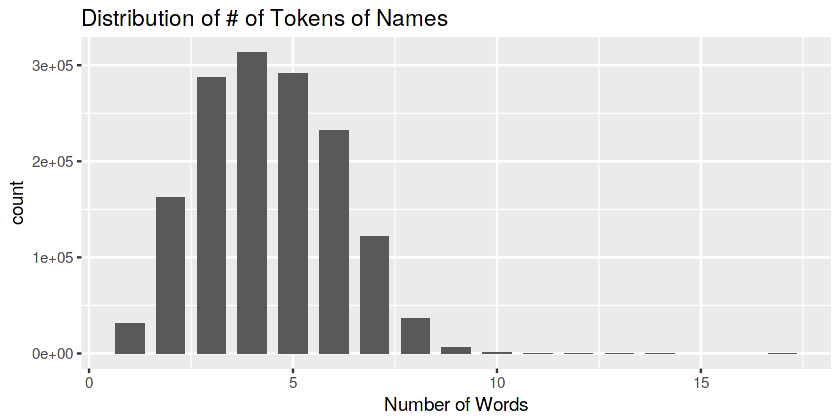

In [18]:
options(repr.plot.width=7, repr.plot.height=3.5)

train = train %>% mutate(num_token_name = str_count(name, '\\S+'))
train %>%
ggplot(aes(x=num_token_name)) +
geom_bar(width=0.7) +
ggtitle('Distribution of # of Tokens of Names') +
xlab('Number of Words')

A very intuitive question would be: does the item name include its category and brand information? We know that the 3-level categories has been a very detailed classification of all the items. We can see how many items include their 3rd categories and brands in their names.

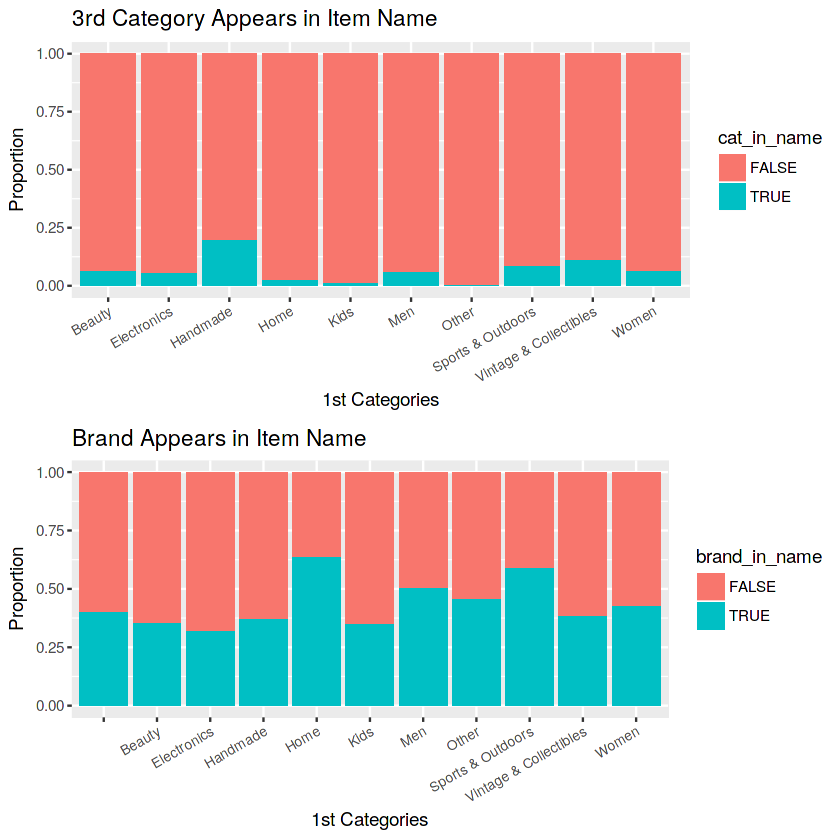

In [19]:
options(repr.plot.width=7, repr.plot.height=7)

p1 = train %>% filter(cat1!='') %>% 
mutate(cat3 = as.character(cat3)) %>% 
mutate(cat_in_name = (str_detect(name, cat3))) %>% 
ggplot(aes(x=cat1, fill=cat_in_name)) +
geom_bar(position='fill') +
theme(axis.text.x=element_text(angle=30, hjust=1, size=8)) +
xlab('1st Categories') +
ylab('Proportion') +
ggtitle('3rd Category Appears in Item Name')

p2 = train %>% filter(has_brand) %>% 
mutate(brand_name = as.character(brand_name)) %>% 
mutate(brand_in_name = (str_detect(name, brand_name))) %>% 
ggplot(aes(x=cat1, fill=brand_in_name)) +
geom_bar(position='fill') +
theme(axis.text.x=element_text(angle=30, hjust=1, size=8)) +
xlab('1st Categories') +
ylab('Proportion') +
ggtitle('Brand Appears in Item Name')

grid.arrange(p1, p2, ncol=1)

It appears that few item names include their categories, but many items include their brands.

If we look at the brand_in_name information by brands, we can surprisingly see that it varies a lot by brands. For example, many of the Nike products contain 'Nike' in their names while Apple products don't show this trend —— perhaps they are named 'iphone' or 'macbook' and everyone knows they are from Apple.

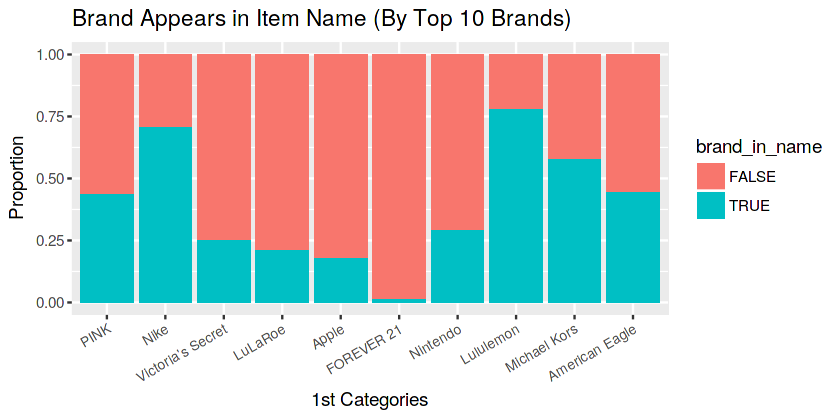

In [20]:
options(repr.plot.width=7, repr.plot.height=3.5)

train %>% filter(brand_name %in% top10$brand_name) %>%
mutate(brand_name = as.character(brand_name)) %>% 
mutate(brand_in_name = (str_detect(name, brand_name))) %>% 
ggplot(aes(x=factor(brand_name, levels=top10$brand_name), fill=brand_in_name)) +
geom_bar(position='fill') +
theme(axis.text.x=element_text(angle=30, hjust=1, size=8)) +
xlab('1st Categories') +
ylab('Proportion') +
ggtitle('Brand Appears in Item Name (By Top 10 Brands)')

This is just a very initial step to look at item names. More information can be extract from this feature.

# Interaction with Price

Our objective is to predict price. Here below shows the relation between some major features and the response log price. The main purpose of this section is to give you some inspirations on creating useful features.

First we will see the predictive power of condition and shiping info. Unfortunately the mean price doesn't vary too much. We can see that even though we take log to the price, there are still lots of outliers.

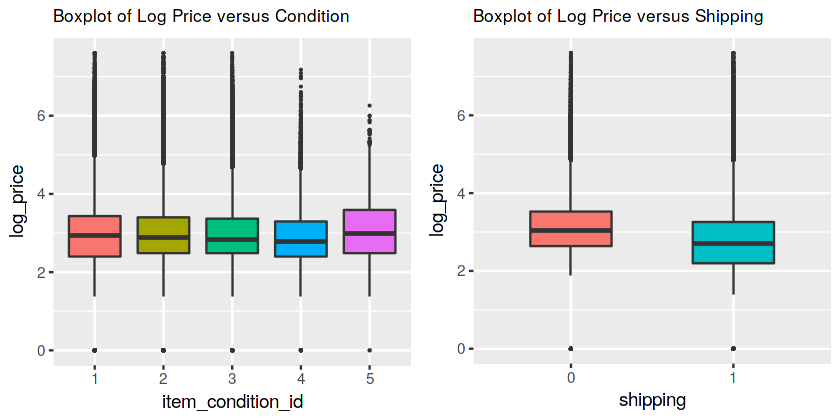

In [21]:
options(repr.plot.width=7, repr.plot.height=3.5)

p1 = train %>%
ggplot(aes(x=item_condition_id, y=log_price, fill=item_condition_id)) +
geom_boxplot(outlier.size=0.1) +
ggtitle('Boxplot of Log Price versus Condition') +
theme(legend.position="none", plot.title = element_text(size=10))

p2 = train %>%
ggplot(aes(x=shipping, y=log_price, fill=shipping)) +
geom_boxplot(width=0.5, outlier.size=0.1) +
ggtitle('Boxplot of Log Price versus Shipping') +
theme(legend.position="none", plot.title = element_text(size=10))

grid.arrange(p1, p2, ncol=2)

The item is more expensive If the shipping fee is expected to be paid by the buyer.

Next we would like to investigate the predictive power of categories and brands.

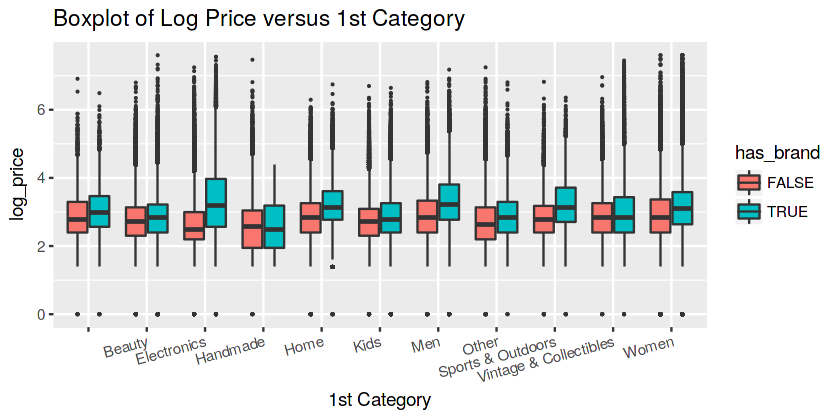

In [22]:
options(repr.plot.width=7, repr.plot.height=3.5)

train %>%
ggplot(aes(x=cat1, y=log_price, fill=has_brand)) +
geom_boxplot(outlier.size=0.1) +
ggtitle('Boxplot of Log Price versus 1st Category') +
xlab('1st Category') +
theme(axis.text.x=element_text(angle=15, hjust=1))

The price don't differ too much between different categories. However, there is a clear trend that items with brands have higher price than items without brands, especially for the electronics. 

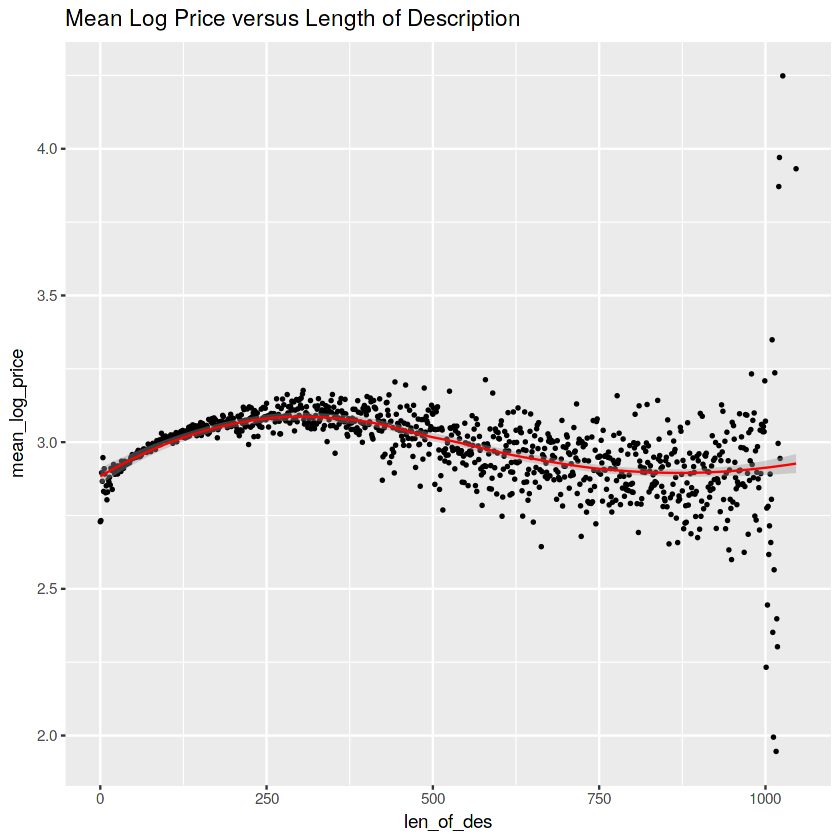

In [23]:
options(repr.plot.width=7, repr.plot.height=7)

train %>% mutate(len_of_des = str_length(item_description)) %>%
group_by(len_of_des) %>%
summarise(mean_log_price = mean(log_price)) %>% 
ggplot(aes(x=len_of_des, y=mean_log_price)) +
geom_point(size=0.5) +
geom_smooth(method = "loess", color = "red", size=0.5) +
ggtitle('Mean Log Price versus Length of Description')

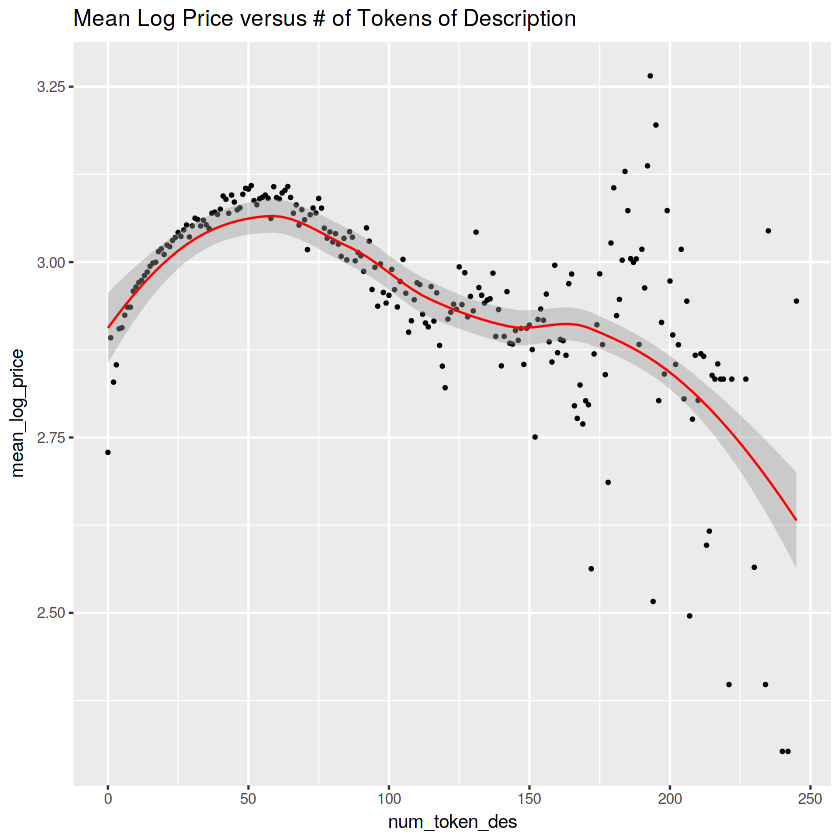

In [24]:
options(repr.plot.width=7, repr.plot.height=7)

train %>% mutate(num_token_des = str_count(item_description, '\\S+')) %>%
group_by(num_token_des) %>%
summarise(mean_log_price = mean(log_price)) %>% 
ggplot(aes(x=num_token_des, y=mean_log_price)) +
geom_point(size=0.5) +
geom_smooth(method = "loess", color = "red", size=0.5) +
ggtitle('Mean Log Price versus # of Tokens of Description')

There is a very interesting quadratic trend between # of words of description and the price. Note that when the # of words increases, the sample size for each point decreases exponentially, the variance of the mean log price then becomes large due to the central limit theorem.